In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


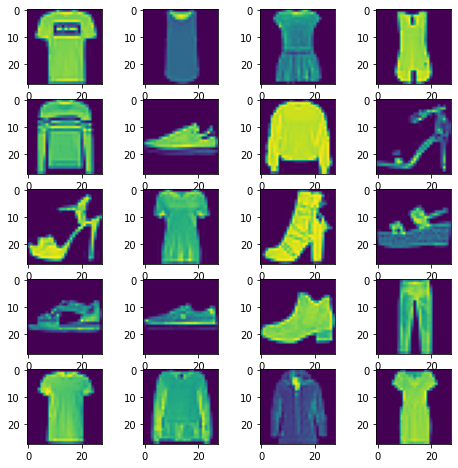

In [3]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [4]:
print("before: "+str(X_train.shape))
# reshape dataset to have a single channel
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
print("after: "+str(X_train.shape))
print("before: "+str(y_train.shape))

before: (60000, 28, 28)
after: (60000, 28, 28, 1)
before: (60000,)


In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize to range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=80, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=80, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [8]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 8.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=0f7e65c7fd9e4dcc7f7fed507dfb6fc2ba432539eea58c60fd82c357f7490690
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=4beaba93d6f4d0a77ff9e3db0bd653d0c494e63fb46ddbe92e1858087ff1a846
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [9]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist Fashion")

In [10]:
tuner_search.search(X_train, y_train, epochs=5,validation_split=0.1)

Trial 5 Complete [00h 00m 28s]
val_accuracy: 0.8964999914169312

Best val_accuracy So Far: 0.9049999713897705
Total elapsed time: 00h 02m 57s
INFO:tensorflow:Oracle triggered exit


In [11]:
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 96)                9

In [12]:
model.fit(X_train,y_train, epochs=10, validation_split=0.1, initial_epoch=5)

Epoch 6/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1903 - accuracy: 0.9269 - val_loss: 0.2470 - val_accuracy: 0.9107
Epoch 7/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1647 - accuracy: 0.9380 - val_loss: 0.2449 - val_accuracy: 0.9140
Epoch 8/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1518 - accuracy: 0.9439 - val_loss: 0.2890 - val_accuracy: 0.8983
Epoch 9/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1353 - accuracy: 0.9485 - val_loss: 0.2544 - val_accuracy: 0.9158
Epoch 10/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1164 - accuracy: 0.9572 - val_loss: 0.2544 - val_accuracy: 0.9212


In [13]:
val_loss,val_accuracy=model.evaluate(X_test,y_test)
print(val_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3012 - accuracy: 0.9124
0.9124000072479248
